# Variant calling with bcftools and custom function

- Bcftools creates pileup from bam file, which in our case was generated using minimap2. To the variant calling, custom thresholds can be set.

### Goal of the analysis

- Identify variants based on quality (e.g Phred quality score) & Alignment frequency
- If there are multiple variants, check which occur together and which are seperated (mixed population).
- Check if the variant is an actual variant or sequencing error


In [46]:
import sys
import os
import importlib
import pandas as pd
import numpy as np
import seaborn as sns
import pysam 
import subprocess
from pathlib import Path
from uncertainties import ufloat
from collections import Counter
from matplotlib import pyplot as plt
from itertools import combinations
from scipy.stats import chi2_contingency, fisher_exact


sys.path.append("/home/emre/github_repo/MinION")

from minION import analyser
from minION import consensus
from minION.util import IO_processor
importlib.reload(IO_processor)
importlib.reload(analyser)
importlib.reload(consensus)

<module 'minION.consensus' from '/home/emre/github_repo/MinION/minION/consensus.py'>

In [4]:
def call_and_filter_vcf(input_path, reference, allele_frequency):
    """ Uses bcftools to call variants and filter them based on allele frequency.
    Args:
        - input_path (str): Path to the input files.
        - reference (str): Path to the reference genome.
        - allele_frequency (float): Allele frequency threshold.
    Returns:
        - Subprocess run
    """
    
    
    prompt_pileup = f"bcftools mpileup -d 4000 -Ou -f {reference}  {input_path}/alignment.bam > {input_path}/pileup.bcf"

    prompt_call = f"bcftools call -mv -Ob -o {input_path}/raw_variants.bcf {input_path}/pileup.bcf"

    prompt_view = f"bcftools view -i 'INFO/AF>{allele_frequency}' -Ob -o {input_path}/filtered_variants.vcf {input_path}/raw_variants.bcf"


    subprocess.run(prompt_pileup, shell=True)

    subprocess.run(prompt_call, shell=True)

    subprocess.run(prompt_view, shell=True)

    print(f"Variant calling and filtering completed. Output saved to {input_path}/raw_variants_python.bcf")


def extract_positions_from_vcf(vcf_file : str) -> list:
    """ Extracts the positions of the variants from a VCF file.
    Args:
        - vcf_file (str): Path to the VCF file. 
    Returns:
        - positions (list): List of variant positions.
    """
    positions = []
 
    vcf = pysam.VariantFile(vcf_file)

    for record in vcf:
        positions.append(record.pos)
    
    vcf.close()

    return positions

def extract_mutations_from_vcf(vcf_file):
    """ Extracts the mutations from a VCF file.
    Args:
        - vcf_file (str): Path to the VCF file.
    Returns:
        - formatted_mutations (str): Formatted mutations (e.g A100T_G223C).
    """

    mutations = []

    vcf = pysam.VariantFile(vcf_file)

    for record in vcf:

        ref_allele = record.ref
        alt_alleles = record.alts

        for alt_allele in alt_alleles:
            position = record.pos
            mutation = f"{ref_allele}{position}{alt_allele}"
            mutations.append(mutation)

    vcf.close()

    formatted_mutations = "_".join(mutations)

    return formatted_mutations


def get_base_counts_at_position(bam_file, chrom, position):
    """
    Extract unique bases and gaps (deletions) and their counts from a BAM file 
    at a specific position using pileup.
    
    Args:
    - bam_file (str): path to the BAM file.
    - chrom (str): chromosome or contig name.
    - position (int): 1-based position to extract bases from.

    Returns:
    - dict: unique bases and gaps with their counts at the specified position.
    """
    
    bases = []

    
    with pysam.AlignmentFile(bam_file, 'rb') as bam:
        for pileup_column in bam.pileup(chrom, position - 1, position, 
                                        min_base_quality=0, 
                                        min_mapping_quality=0, 
                                        truncate=True):
            if pileup_column.pos == position - 1: 
                for pileup_read in pileup_column.pileups:
                    if pileup_read.is_del:
                        bases.append("-")  
                    elif not pileup_read.is_refskip:
                        bases.append(pileup_read.alignment.query_sequence[pileup_read.query_position])

    base_counts = Counter(bases)

    return base_counts


def generate_heatmap_data(bam_file, chrom, positions):
    data = []
    all_bases = set(['A', 'T', 'C', 'G', '-'])
    for position in positions:
        base_counts = get_base_counts_at_position(bam_file, chrom, position)
        col = [base_counts.get(base, 0) for base in all_bases]
        data.append(col)
    df = pd.DataFrame(data, index=positions, columns=list(all_bases))
    # Order as in all_bases
    # TODO: Specify if a character if it is an actual gap or no coverage
    df = df[['A', 'T', 'C', 'G', '-']]
    return df




def get_most_common_base(position, heatmap_data, ref_base):
    non_ref_data = heatmap_data.loc[position].drop(ref_base)
    return non_ref_data.idxmax(), non_ref_data.max()



def get_bases_from_pileup(bam_file, chrom, positions):
    bases_dict = {position: {} for position in positions}
    
    with pysam.AlignmentFile(bam_file, 'rb') as bam:
        for pileup_column in bam.pileup(chrom, min(positions) - 1, max(positions) + 1,
                                        min_base_quality=0, 
                                        min_mapping_quality=0, 
                                        truncate=True):
            if pileup_column.pos + 1 in positions:
                for pileup_read in pileup_column.pileups:
                    if not pileup_read.is_del and not pileup_read.is_refskip:
                        base = pileup_read.alignment.query_sequence[pileup_read.query_position]
                        read_name = pileup_read.alignment.query_name
                        # Check if the read name is already added to the bases_dict for that position
                        if read_name not in bases_dict[pileup_column.pos + 1]:
                            bases_dict[pileup_column.pos + 1][read_name] = base

    # Get unique read names and sort them to have a consistent order
    read_names = sorted(set().union(*[bases_dict[pos].keys() for pos in bases_dict]))

    # Create DataFrame
    df = pd.DataFrame(index=read_names, columns=positions)
    
    # Populate DataFrame
    for pos in positions:
        for read_name, base in bases_dict[pos].items():
            df.at[read_name, pos] = base
    
    # Fill NaN with "-"
    df = df.fillna("-")

    return df

In [5]:
barcodes = IO_processor.get_barcode_dict(Path("/home/emre/minION_results/MinION_RBC_0902723_sup/Demultiplex_cpp_70_short"))
#path_to_bam = "/home/emre/minION_results/MinION_RBC_0902723_sup/Demultiplex_cpp_70_short/RB03/NB08/consensus"
path_to_bam = "/home/emre/minION_results/TamLQV96_sup/Demultiplex_cpp_70/RB03/NB09/consensus"
#template_fasta = "/home/emre/github_repo/MinION/minION/refseq/hetcpiii.fasta"
template_fasta = Path("/home/emre/tam-lqv.fasta")
output_vcf = f"{path_to_bam}/raw_variants.vcf"
#consensus.get_consensus(Path(path_to_bam), Path(template_fasta))
call_and_filter_vcf(path_to_bam, template_fasta, 0.4)


Variant calling and filtering completed. Output saved to /home/emre/minION_results/TamLQV96_sup/Demultiplex_cpp_70/RB03/NB09/consensus/raw_variants_python.bcf


[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 4000
Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid


In [66]:
extract_mutations_from_vcf(f'{path_to_bam}/filtered_variants.vcf')

'A158G_G346A_C417T_C481T_T530A'

In [67]:
nb_positions = extract_positions_from_vcf(f'{path_to_bam}/filtered_variants.vcf')

In [6]:
bam_file = f'{path_to_bam}/alignment.bam'

In [7]:
#reference = "HetCPIII"
reference = "Tam-LQV"  
position_to_check = 1  
bases_at_position = get_base_counts_at_position(bam_file, reference, position_to_check)
bases_at_position

Counter({'A': 430})

In [70]:
#heatmap_data = generate_heatmap_data(bam_file, reference, 1, 100)
heatmap_data = generate_heatmap_data(bam_file, reference, nb_positions)

In [71]:
heatmap_data

,A,T,C,G,-
158,14,1,3,444,15
346,460,0,4,9,4
417,1,463,6,0,7
481,7,447,10,8,5
530,463,5,1,1,7


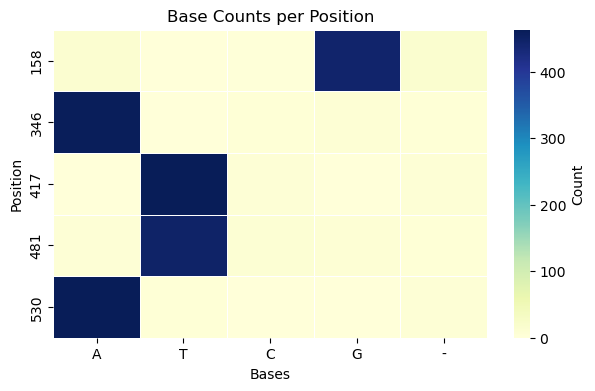

In [45]:

template = analyser.get_template_sequence(template_fasta)

# Plotting
plt.figure(figsize=(7, 4))
sns.heatmap(heatmap_data, 
            annot=False, 
            cmap='YlGnBu', 
            cbar_kws={'label': 'Count'}, 
            linewidths=0.5, 
            linecolor='white')
plt.title("Base Counts per Position")
plt.xlabel("Bases")
plt.ylabel("Position")
plt.show()

In [10]:
ref_seq = analyser.get_template_sequence(template_fasta)
#freq_dist = pd.DataFrame(get_highest_non_ref_base_freq(bam_file, reference, range(1,len(ref_seq)), ref_seq)).T

In [76]:
# Replace NaN value with "T"
freq_dist[0] = freq_dist[0].fillna("T")

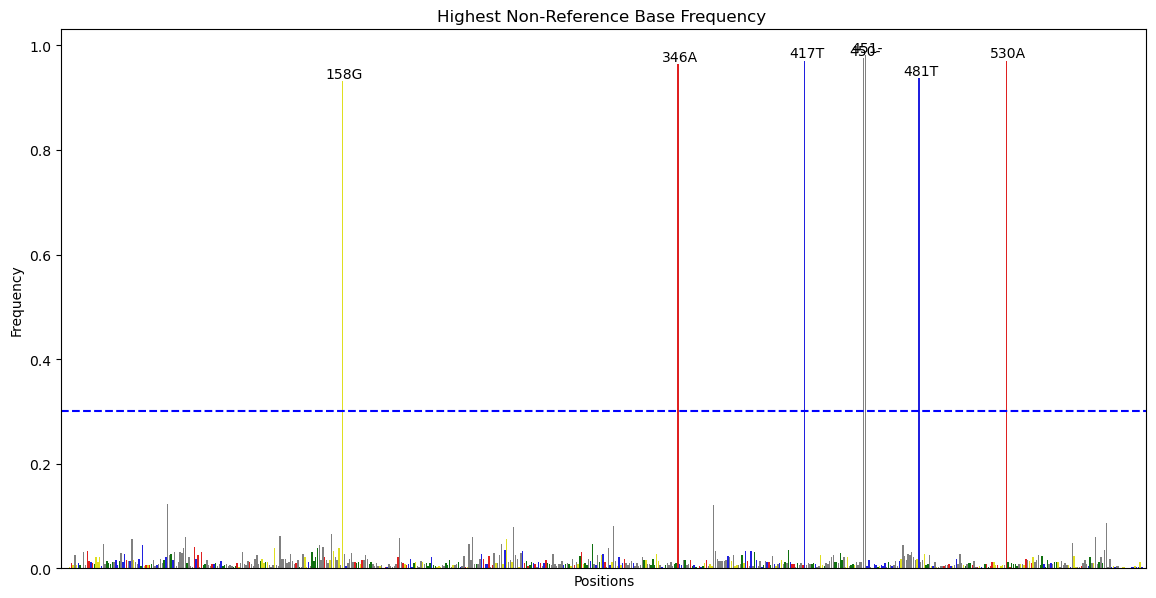

In [77]:
colors_for_bases = {"-" : "grey", "A" : "red", "T" : "blue", "C" : "green", "G" : "yellow", "None" : "black"}

freq_dist = freq_dist.rename(columns={0:"Base", 1:"Frequency"})

freq_dist["Base"] = freq_dist["Base"].fillna("None")

freq_dist = freq_dist.dropna()

freq_dist["Color"] = freq_dist["Base"].map(colors_for_bases)


# Plotting
plt.figure(figsize=(14, 7))
sns.barplot(x=freq_dist.index, y=freq_dist["Frequency"], palette=freq_dist["Color"])
plt.title("Highest Non-Reference Base Frequency ")
plt.xticks([])
plt.xlabel("Positions")
plt.ylabel("Frequency")
# TODO Add horizontal line at 2 mean std deviation
plt.axhline(y=0.3, color='b', linestyle='--')
# TODO Add legend for bases
for index, row in freq_dist.iterrows():
    if row["Frequency"] > 0.3:
        plt.text(index, row["Frequency"], f"{index}{row['Base']}", color='black', ha="center", va='bottom')

plt.show()

#plt.savefig("/home/emre/minION_results/MinION_RBC_0902723_sup/variant_freq_RB02_NB10.png")


Contingency Table for pair (158, 346)
         B  Not B
A      433     29
Not A   13      4
P-value: 0.023162698833070466
Contingency Table for pair (158, 417)
         B  Not B
A      433     32
Not A   13      3
P-value: 0.19102655158800785
Contingency Table for pair (158, 481)
         B  Not B
A      419     30
Not A   27      5
P-value: 0.12611271949080302
Contingency Table for pair (158, 530)
         B  Not B
A      433     32
Not A   13      3
P-value: 0.19102655158800785
Contingency Table for pair (346, 417)
         B  Not B
A      450     15
Not A   12      4
P-value: 0.00018127445851584453
Contingency Table for pair (346, 481)
         B  Not B
A      434     15
Not A   28      4
P-value: 0.03570004760700291
Contingency Table for pair (346, 530)
         B  Not B
A      451     14
Not A   11      5
P-value: 4.437887336823507e-07
Contingency Table for pair (417, 481)
         B  Not B
A      439     10
Not A   26      6
P-value: 6.021136159840702e-06
Contingency Table for pa

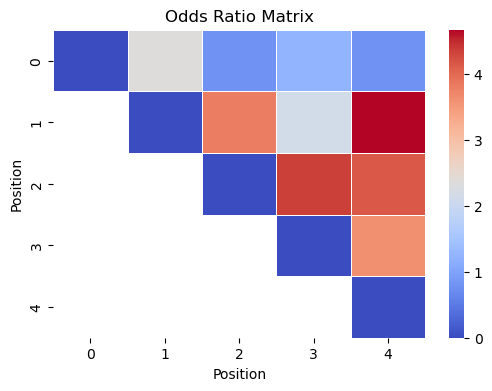

In [93]:
# Calculate for each pair chi-squared test
nb_positions = extract_positions_from_vcf(f'{path_to_bam}/filtered_variants.vcf')
comb = list(combinations(nb_positions, 2))
heatmap_data = generate_heatmap_data(bam_file, reference, nb_positions)

# Initialize a matrix with zeros for storing the -log10(p-values)
pval_matrix = np.zeros((len(nb_positions), len(nb_positions)))
odds_ratio_matrix = np.zeros((len(nb_positions), len(nb_positions)))


for pair in comb:
    
    max_nucleotide_pair1, _ = get_most_common_base(pair[0], heatmap_data, template[pair[0] - 1])
    max_nucleotide_pair2, _ = get_most_common_base(pair[1], heatmap_data, template[pair[1] - 1])

    bases_df = get_bases_from_pileup(bam_file, reference, pair)

    A_and_B = len(bases_df[(bases_df[pair[0]] == max_nucleotide_pair1) & (bases_df[pair[1]] == max_nucleotide_pair2)])
    A_wo_B = len(bases_df[(bases_df[pair[0]] == max_nucleotide_pair1) & (bases_df[pair[1]] != max_nucleotide_pair2)])
    B_wo_A = len(bases_df[(bases_df[pair[0]] != max_nucleotide_pair1) & (bases_df[pair[1]] == max_nucleotide_pair2)])
    wo_A_and_B = len(bases_df[(bases_df[pair[0]] != max_nucleotide_pair1) & (bases_df[pair[1]] != max_nucleotide_pair2)])



    contingency_table = pd.DataFrame({
        'B': [A_and_B, A_wo_B],
        'Not B': [B_wo_A, wo_A_and_B]
    }, index=['A', 'Not A'])

    # Laplaci correction
    contingency_table += 1

    #chi2, p_value, _, _ = chi2_contingency(contingency_table)

    # Fisher's exact test
    #oddsratio, p_value = fisher_exact(contingency_table)

    # Chi-squared test
    oddsratio, p_value, _, _ = chi2_contingency(contingency_table)

    oddsratio = np.log2(oddsratio)
    odds_ratio_matrix[nb_positions.index(pair[0])][nb_positions.index(pair[1])] = oddsratio


    print("Contingency Table for pair", pair)
    print(contingency_table)
    print("P-value:", p_value)

    neg_log_p_value = -np.log10(p_value)

    # Store the values in the matrix
    pval_matrix[nb_positions.index(pair[0])][nb_positions.index(pair[1])] = neg_log_p_value



# Masking the lower triangle of the matrix
mask = np.tri(pval_matrix.shape[0], k=-1)

# Plotting the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(odds_ratio_matrix, cmap='coolwarm', mask=mask, linewidths=0.5, linecolor='white')
sns.xticklabels = nb_positions
sns.yticklabels = nb_positions
#Label the axes
plt.xlabel('Position')
plt.ylabel('Position')
plt.title("Odds Ratio Matrix")
plt.show()



In [16]:
barcode_dicts = IO_processor.get_barcode_dict(Path("/home/emre/minION_results/TamLQV96_sup/Demultiplex_cpp_70"))
demultiplex_folder = Path("/home/emre/minION_results/TamLQV96_sup/Demultiplex_cpp_70")

In [17]:
bases, qualities = analyser.get_highest_non_ref_base_freq(bam_file, reference, range(1,len(ref_seq)), ref_seq)

In [47]:
variant_df = analyser.get_variant_df_custom(demultiplex_folder, template_fasta, barcode_dicts, consensus_folder_name = "consensus", merge = True)

/home/emre/minION_results/TamLQV96_sup/Demultiplex_cpp_70/RB03/NB03/consensus/alignment.bam
/home/emre/minION_results/TamLQV96_sup/Demultiplex_cpp_70/RB03/NB04/consensus/alignment.bam
/home/emre/minION_results/TamLQV96_sup/Demultiplex_cpp_70/RB03/NB10/consensus/alignment.bam
/home/emre/minION_results/TamLQV96_sup/Demultiplex_cpp_70/RB03/NB07/consensus/alignment.bam
/home/emre/minION_results/TamLQV96_sup/Demultiplex_cpp_70/RB03/NB06/consensus/alignment.bam
/home/emre/minION_results/TamLQV96_sup/Demultiplex_cpp_70/RB03/NB12/consensus/alignment.bam
/home/emre/minION_results/TamLQV96_sup/Demultiplex_cpp_70/RB03/NB02/consensus/alignment.bam
/home/emre/minION_results/TamLQV96_sup/Demultiplex_cpp_70/RB03/NB01/consensus/alignment.bam
/home/emre/minION_results/TamLQV96_sup/Demultiplex_cpp_70/RB03/NB08/consensus/alignment.bam
/home/emre/minION_results/TamLQV96_sup/Demultiplex_cpp_70/RB03/NB09/consensus/alignment.bam
Skipping RB03/NB11 because of low read count
/home/emre/minION_results/TamLQV96_

In [23]:
variant_df.dropna(subset=["count"], inplace=True)

In [45]:
variant_df[variant_df["Well"] == "A3"]

,Plate,Well,Position,Variant,Quality-Score,count
2,1,A3,[],[],[],145.0
98,2,A3,[377],[A377G],[21],40.0
194,3,A3,[],[],[],175.0
290,4,A3,[],[],[],51.0
386,5,A3,NaN,NaN,NaN,NaN
482,6,A3,"[61, 577]","[T61C, G577A]","[20, 19]",126.0
578,7,A3,"[438, 560, 561]","[T438C, C560A, T561C]","[20, 18, 18]",144.0
674,8,A3,"[31, 327]","[G31A, T327A]","[22, 20]",77.0
